## Keating Problem

This problem uses a two-dimensional cross-section model to simulate a perched
aquifer overlying a water table aquifer.  The presence of a discontinuous
low permeability lens causes the perched aquifer to form in response to
recharge.  The problem also represents solute transport through the system.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.patches
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwt-keating"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)
gif_save = get_env("GIF", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nlay = 80  # Number of layers
nrow = 1  # Number of rows
ncol = 400  # Number of columns
delr = 25.0  # Column width ($m$)
delc = 1.0  # Row width ($m$)
delz = 25.0  # Layer thickness ($m$)
top = 2000.0  # Top of model domain ($m$)
bottom = 0.0  # Bottom of model domain ($m$)
hka = 1.0e-12  # Permeability of aquifer ($m^2$)
hkc = 1.0e-18  # Permeability of aquitard ($m^2$)
h1 = 800.0  # Head on left side ($m$)
h2 = 100.0  # Head on right side ($m$)
recharge = 0.5  # Recharge ($kg/s$)
recharge_conc = 1.0  # Normalized recharge concentration (unitless)
alpha_l = 1.0  # Longitudinal dispersivity ($m$)
alpha_th = 1.0  # Transverse horizontal dispersivity ($m$)
alpha_tv = 1.0  # Transverse vertical dispersivity ($m$)
period1 = 730  # Length of first simulation period ($d$)
period2 = 29270.0  # Length of second simulation period ($d$)
porosity = 0.1  # Porosity of mobile domain (unitless)
obs1 = (49, 1, 119)  # Layer, row, and column for observation 1
obs2 = (77, 1, 359)  # Layer, row, and column for observation 2

obs1 = tuple([i - 1 for i in obs1])
obs2 = tuple([i - 1 for i in obs2])
seconds_to_days = 24.0 * 60.0 * 60.0
permeability_to_conductivity = 1000.0 * 9.81 / 1.0e-3 * seconds_to_days
hka = hka * permeability_to_conductivity
hkc = hkc * permeability_to_conductivity
botm = [top - (k + 1) * delz for k in range(nlay)]
x = np.arange(0, 10000.0, delr) + delr / 2.0
plotaspect = 1.0

# Fill hydraulic conductivity array
hydraulic_conductivity = np.ones((nlay, nrow, ncol), dtype=float) * hka
for k in range(nlay):
    if 1000.0 <= botm[k] < 1100.0:
        for j in range(ncol):
            if 3000.0 <= x[j] <= 6000.0:
                hydraulic_conductivity[k, 0, j] = hkc

# Calculate recharge by converting from kg/s to m/d
rcol = []
for jcol in range(ncol):
    if 4200.0 <= x[jcol] <= 4800.0:
        rcol.append(jcol)
number_recharge_cells = len(rcol)
rrate = recharge * seconds_to_days / 1000.0
cell_area = delr * delc
rrate = rrate / (float(number_recharge_cells) * cell_area)
rchspd = {}
rchspd[0] = [[(0, 0, j), rrate, recharge_conc] for j in rcol]
rchspd[1] = [[(0, 0, j), rrate, 0.0] for j in rcol]

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_mf6gwf():
    print(f"Building mf6gwf model...{sim_name}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_name, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = ((period1, 1, 1.0), (period2, 1, 1.0))
    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_ds), perioddata=tdis_ds, time_units=time_units
    )
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        no_ptcrecord="all",
        outer_dvclose=1.0e-4,
        outer_maximum=2000,
        under_relaxation="dbd",
        linear_acceleration="BICGSTAB",
        under_relaxation_theta=0.7,
        under_relaxation_kappa=0.08,
        under_relaxation_gamma=0.05,
        under_relaxation_momentum=0.0,
        backtracking_number=20,
        backtracking_tolerance=2.0,
        backtracking_reduction_factor=0.2,
        backtracking_residual_limit=5.0e-4,
        inner_dvclose=1.0e-5,
        rcloserecord="0.0001 relative_rclose",
        inner_maximum=100,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=name, save_flows=True, newtonoptions=["newton"]
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=1,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=600.0)
    chdspd = [[(k, 0, 0), h1] for k in range(nlay) if botm[k] < h1]
    chdspd += [[(k, 0, ncol - 1), h2] for k in range(nlay) if botm[k] < h2]
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chdspd,
        print_input=True,
        print_flows=True,
        save_flows=False,
        pname="CHD-1",
    )
    flopy.mf6.ModflowGwfrch(
        gwf,
        stress_period_data=rchspd,
        auxiliary=["concentration"],
        pname="RCH-1",
    )

    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[
            ("HEAD", "ALL"),
            ("BUDGET", "ALL"),
        ],
    )
    return sim


def build_mf6gwt():
    print(f"Building mf6gwt model...{sim_name}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_name, "mf6gwt")
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=sim_ws,
        exe_name="mf6",
        continue_=True,
    )
    tdis_ds = ((period1, 73, 1.0), (period2, 2927, 1.0))
    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_ds), perioddata=tdis_ds, time_units=time_units
    )
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        outer_dvclose=1.0e-4,
        outer_maximum=100,
        under_relaxation="none",
        linear_acceleration="BICGSTAB",
        rcloserecord="1000.0 strict",
        inner_maximum=20,
        inner_dvclose=1.0e-4,
        relaxation_factor=0.0,
        number_orthogonalizations=2,
        preconditioner_levels=8,
        preconditioner_drop_tolerance=0.001,
    )
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    flopy.mf6.ModflowGwtadv(gwt, scheme="upstream")
    flopy.mf6.ModflowGwtdsp(
        gwt, xt3d_off=True, alh=alpha_l, ath1=alpha_th, atv=alpha_tv
    )
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, flow_imbalance_correction=True, packagedata=pd)
    sourcerecarray = [
        ("RCH-1", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    saverecord = {
        0: [
            ("CONCENTRATION", "STEPS", 10),
            ("CONCENTRATION", "LAST"),
            ("CONCENTRATION", "FREQUENCY", 10),
        ],
        1: [
            ("CONCENTRATION", "STEPS", 27, 227),
            ("CONCENTRATION", "LAST"),
            ("CONCENTRATION", "FREQUENCY", 10),
        ],
    }
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.cbc",
        concentration_filerecord=f"{name}.ucn",
        concentrationprintrecord=[
            ("COLUMNS", ncol, "WIDTH", 15, "DIGITS", 6, "GENERAL")
        ],
        saverecord=saverecord,
        printrecord=[
            ("CONCENTRATION", "LAST"),
            ("BUDGET", "ALL"),
        ],
    )
    obs_data = {
        f"{name}.obs.csv": [
            ("obs1", "CONCENTRATION", obs1),
            ("obs2", "CONCENTRATION", obs2),
        ],
    }
    flopy.mf6.ModflowUtlobs(gwt, digits=10, print_input=True, continuous=obs_data)
    return sim


def build_models():
    sim_mf6gwf = build_mf6gwf()
    sim_mf6gwt = build_mf6gwt()
    sim_mf2005 = None  # build_mf2005()
    sim_mt3dms = None  # build_mt3dms(sim_mf2005)
    return sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms


def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)


@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    success, buff = sim_mf6gwf.run_simulation(silent=silent)
    assert success, buff
    success, buff = sim_mf6gwt.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (7.5, 3)


def plot_results(sims):
    print("Plotting model results...")
    plot_head_results(sims)
    plot_conc_results(sims)
    plot_cvt_results(sims)
    if plot_save and gif_save:
        make_animated_gif(sims)


def plot_head_results(sims):
    print("Plotting head model results...")
    sim_mf6gwf, _, _, _ = sims
    gwf = sim_mf6gwf.flow
    botm = gwf.dis.botm.array

    with styles.USGSMap():
        sim_ws = sim_mf6gwf.simulation_data.mfpath.get_sim_path()
        head = gwf.output.head().get_data()
        head = np.where(head > botm, head, np.nan)
        fig, ax = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
        pa = pxs.plot_array(head, head=head, cmap="jet")
        pxs.plot_bc(ftype="RCH", color="red")
        pxs.plot_bc(ftype="CHD")
        plt.colorbar(pa, shrink=0.5)
        confining_rect = matplotlib.patches.Rectangle(
            (3000, 1000), 3000, 100, color="gray", alpha=0.5
        )
        ax.add_patch(confining_rect)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("elevation (m)")
        ax.set_aspect(plotaspect)

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-head.png"
            fpth = figs_path / fname
            fig.savefig(fpth)


def plot_conc_results(sims):
    print("Plotting conc model results...")
    sim_mf6gwf, sim_mf6gwt, _, _ = sims
    gwf = sim_mf6gwf.flow
    gwt = sim_mf6gwt.trans
    botm = gwf.dis.botm.array

    with styles.USGSMap():
        head = gwf.output.head().get_data()
        head = np.where(head > botm, head, np.nan)
        sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
        cobj = gwt.output.concentration()
        conc_times = cobj.get_times()
        conc_times = np.array(conc_times)
        fig, axes = plt.subplots(3, 1, figsize=(7.5, 4.5), dpi=300, tight_layout=True)
        xgrid, _, zgrid = gwt.modelgrid.xyzcellcenters
        # Desired plot times
        plot_times = [100.0, 1000.0, 3000.0]
        nplots = len(plot_times)
        for iplot in range(nplots):
            print(f"  Plotting conc {iplot + 1}")
            time_in_pub = plot_times[iplot]
            idx_conc = (np.abs(conc_times - time_in_pub)).argmin()
            totim = conc_times[idx_conc]
            ax = axes[iplot]
            pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})
            conc = cobj.get_data(totim=totim)
            conc = np.where(head > botm, conc, np.nan)
            pa = pxs.plot_array(conc, head=head, cmap="jet", vmin=0, vmax=1.0)
            pxs.plot_bc(ftype="RCH", color="red")
            pxs.plot_bc(ftype="CHD")
            confining_rect = matplotlib.patches.Rectangle(
                (3000, 1000), 3000, 100, color="gray", alpha=0.5
            )
            ax.add_patch(confining_rect)
            if iplot == 2:
                ax.set_xlabel("x position (m)")
            ax.set_ylabel("elevation (m)")
            title = f"Time = {totim}"
            letter = chr(ord("@") + iplot + 1)
            styles.heading(letter=letter, heading=title, ax=ax)
            ax.set_aspect(plotaspect)

            for k, i, j in [obs1, obs2]:
                x = xgrid[i, j]
                z = zgrid[k, i, j]
                ax.plot(
                    x,
                    z,
                    markerfacecolor="yellow",
                    markeredgecolor="black",
                    marker="o",
                    markersize="4",
                )
        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-conc.png"
            fpth = figs_path / fname
            fig.savefig(fpth)


def make_animated_gif(sims):
    import copy

    import matplotlib as mpl
    from matplotlib.animation import FuncAnimation, PillowWriter

    print("Animating conc model results...")
    sim_mf6gwf, sim_mf6gwt, _, _ = sims
    gwf = sim_mf6gwf.flow
    gwt = sim_mf6gwt.trans
    botm = gwf.dis.botm.array

    # load head
    with styles.USGSMap() as fs:
        head = gwf.output.head().get_data()
        head = np.where(head > botm, head, np.nan)

        # load concentration
        cobj = gwt.output.concentration()
        conc_times = cobj.get_times()
        conc_times = np.array(conc_times)
        conc = cobj.get_alldata()

        # set up the figure
        fig = plt.figure(figsize=(7.5, 3))
        ax = fig.add_subplot(1, 1, 1)
        pxs = flopy.plot.PlotCrossSection(
            model=gwf,
            ax=ax,
            line={"row": 0},
            extent=(0, 10000, 0, 2000),
        )

        cmap = copy.copy(mpl.colormaps["jet"])
        cmap.set_bad("white")
        nodata = -999.0
        a = np.where(head > botm, conc[0], nodata)
        a = np.ma.masked_where(a < 0, a)
        pc = pxs.plot_array(a, head=head, cmap=cmap, vmin=0, vmax=1)
        pxs.plot_bc(ftype="RCH", color="red")
        pxs.plot_bc(ftype="CHD")

        def init():
            ax.set_title(f"Time = {conc_times[0]} days")

        def update(i):
            a = np.where(head > botm, conc[i], nodata)
            a = np.ma.masked_where(a < 0, a)
            a = a[~a.mask]
            pc.set_array(a.flatten())
            ax.set_title(f"Time = {conc_times[i]} days")

        # Stop the animation at 18,000 days
        idx_end = (np.abs(conc_times - 18000.0)).argmin()
        ani = FuncAnimation(fig, update, range(1, idx_end), init_func=init)
        writer = PillowWriter(fps=25)
        fpth = figs_path / f"{sim_name}.gif"
        ani.save(fpth, writer=writer)


def plot_cvt_results(sims):
    print("Plotting cvt model results...")
    _, sim_mf6gwt, _, _ = sims
    gwt = sim_mf6gwt.trans

    with styles.USGSMap():
        sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
        mf6gwt_ra = gwt.obs.output.obs().data
        dt = [("totim", "f8"), ("obs", "f8")]

        fname = "keating_obs1.csv"
        fpath = pooch.retrieve(
            url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
            fname=fname,
            path=data_path,
            known_hash="md5:174c5548c3bbb9ea4ebc8b5a33ea2851",
        )
        obs1ra = np.genfromtxt(fpath, delimiter=",", deletechars="", dtype=dt)

        fname = "keating_obs2.csv"
        fpath = pooch.retrieve(
            url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
            fname=fname,
            path=data_path,
            known_hash="md5:8de2ef529a2537ecd6c62bc207b67fb5",
        )
        obs2ra = np.genfromtxt(fpath, delimiter=",", deletechars="", dtype=dt)
        fig, axes = plt.subplots(2, 1, figsize=(6, 4), dpi=300, tight_layout=True)
        ax = axes[0]
        ax.plot(
            mf6gwt_ra["totim"], mf6gwt_ra["OBS1"], "b-", alpha=1.0, label="MODFLOW 6"
        )
        ax.plot(
            obs1ra["totim"],
            obs1ra["obs"],
            markerfacecolor="None",
            markeredgecolor="k",
            marker="o",
            markersize="4",
            linestyle="None",
            label="Keating and Zyvolosky (2009)",
        )
        ax.set_xlim(0, 8000)
        ax.set_ylim(0, 0.80)
        ax.set_xlabel("time, in days")
        ax.set_ylabel("normalized concentration, unitless")
        styles.graph_legend(ax)
        ax = axes[1]
        ax.plot(
            mf6gwt_ra["totim"], mf6gwt_ra["OBS2"], "b-", alpha=1.0, label="MODFLOW 6"
        )
        ax.plot(
            obs2ra["totim"],
            obs2ra["obs"],
            markerfacecolor="None",
            markeredgecolor="k",
            marker="o",
            markersize="4",
            linestyle="None",
            label="Keating and Zyvolosky (2009)",
        )
        ax.set_xlim(0, 30000)
        ax.set_ylim(0, 0.20)
        ax.set_xlabel("time, in days")
        ax.set_ylabel("normalized concentration, unitless")
        styles.graph_legend(ax)
        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-cvt.png"
            fpth = figs_path / fname
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-keating


Building mf6gwt model...ex-gwt-keating


run_models took 49876.05 ms
Plotting model results...
Plotting head model results...


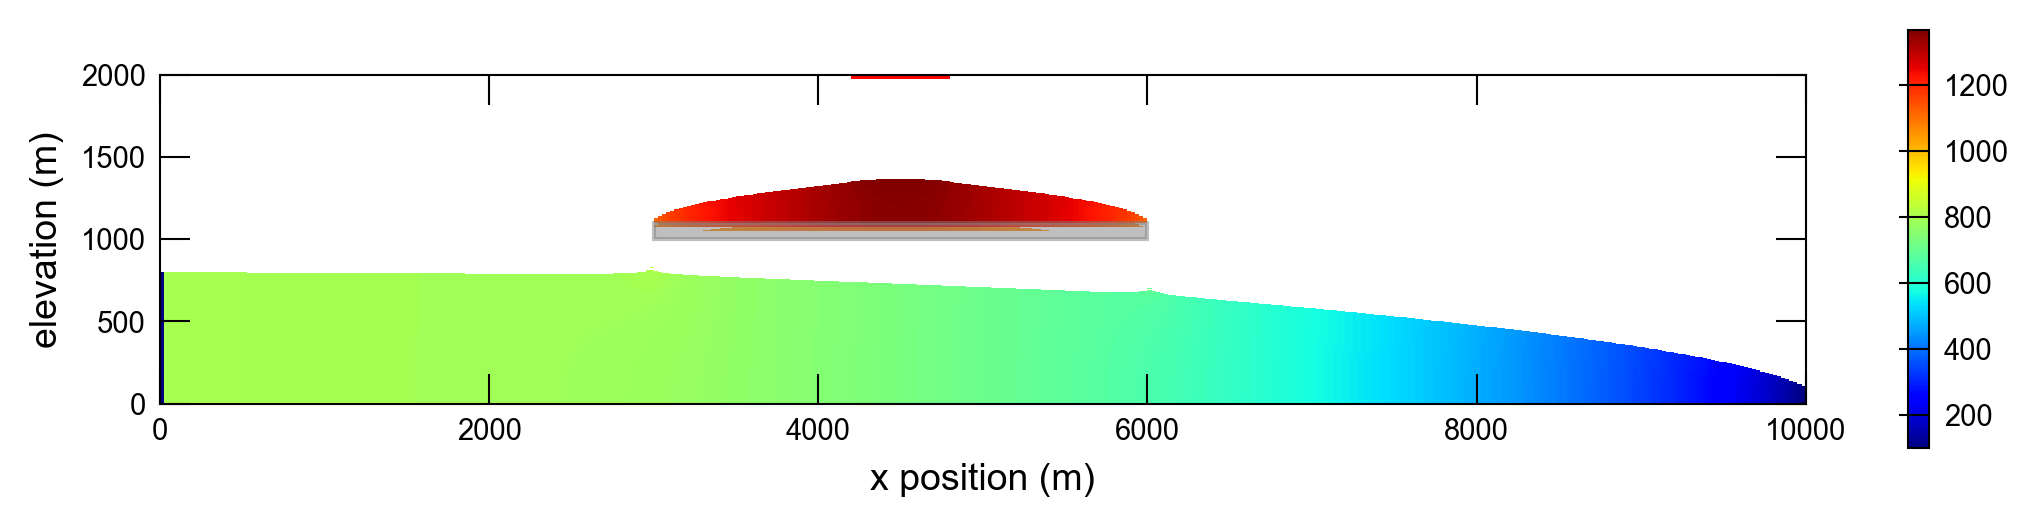

Plotting conc model results...


  Plotting conc 1


  Plotting conc 2


  Plotting conc 3


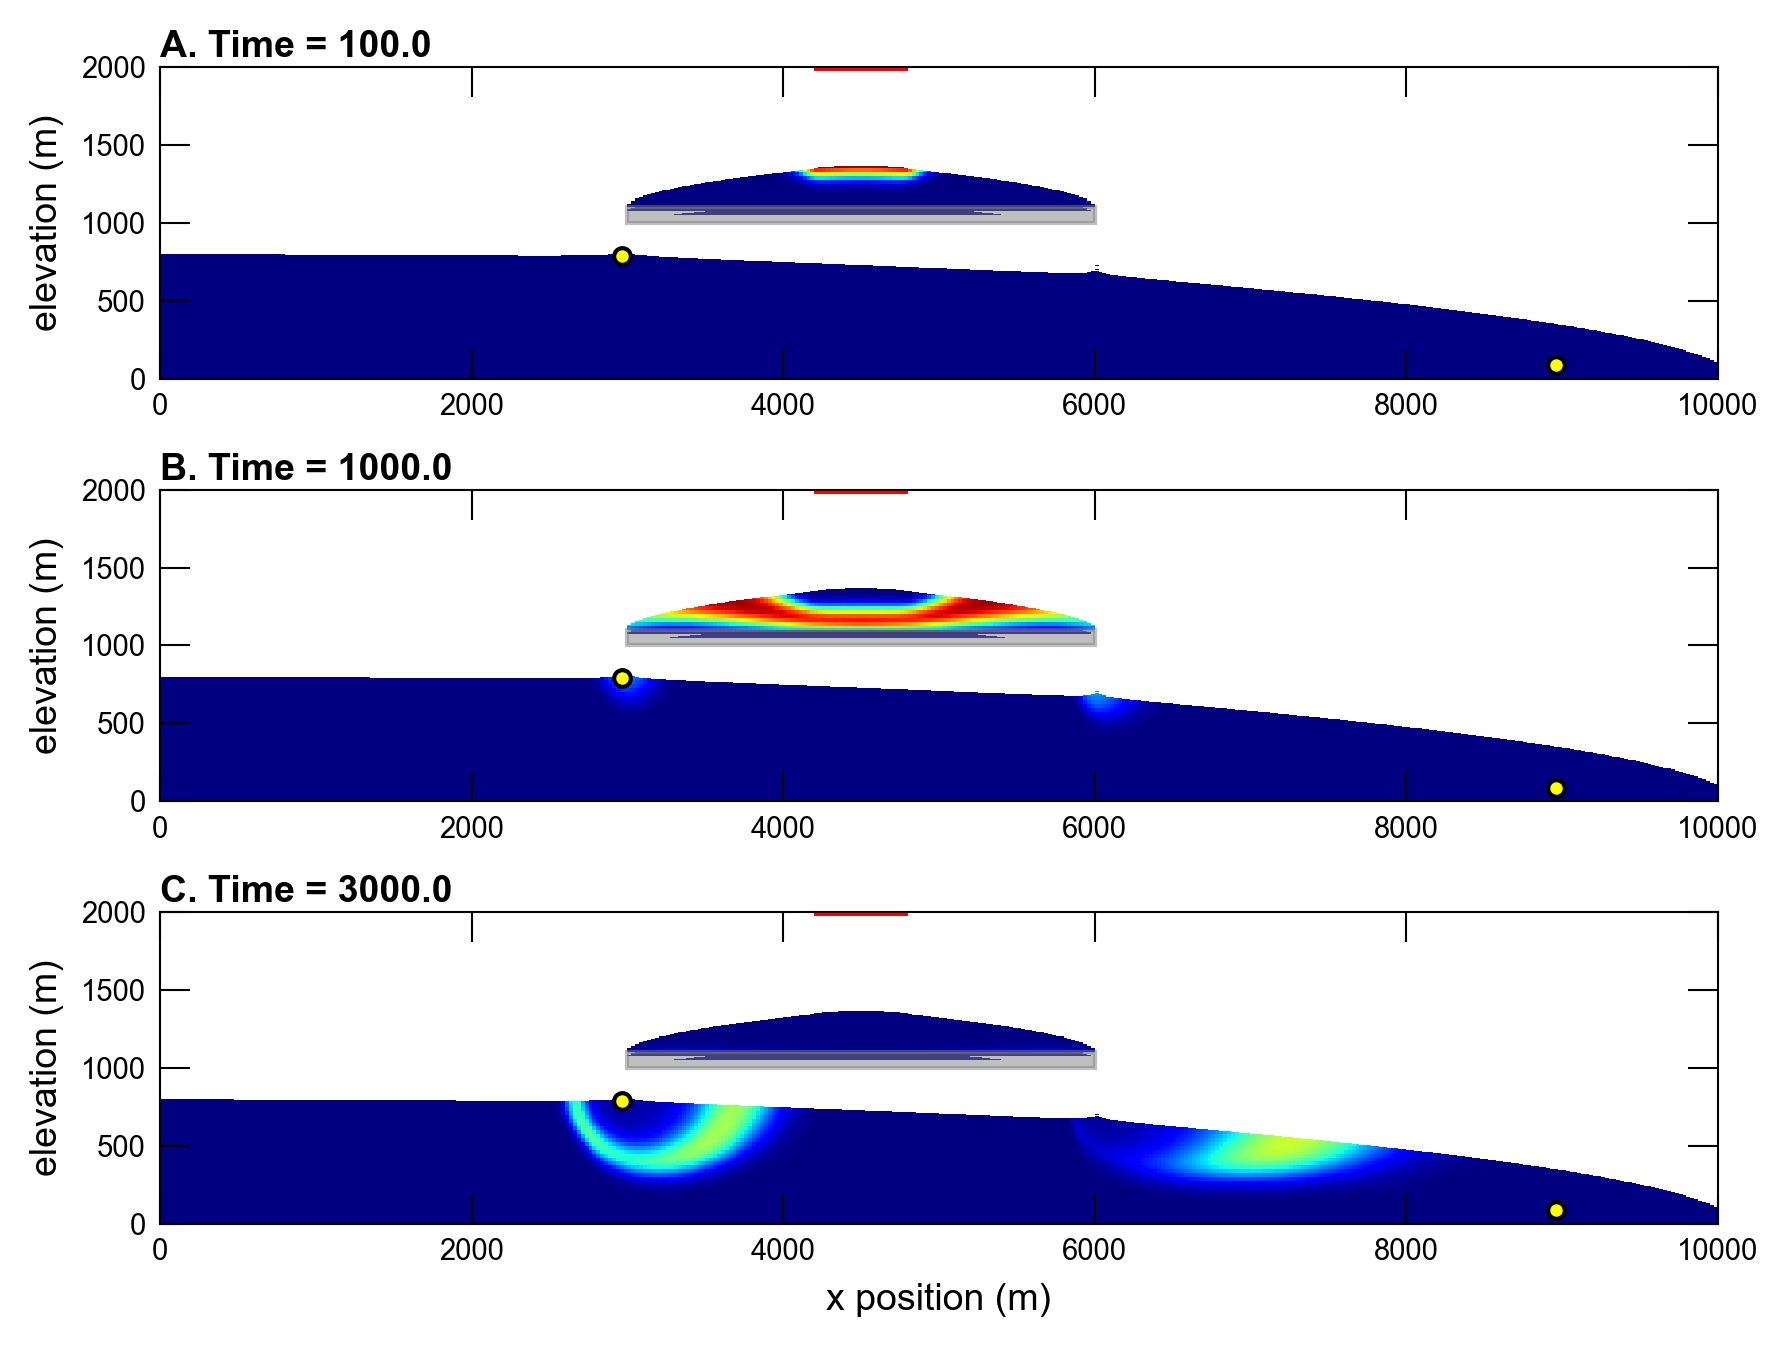

Plotting cvt model results...


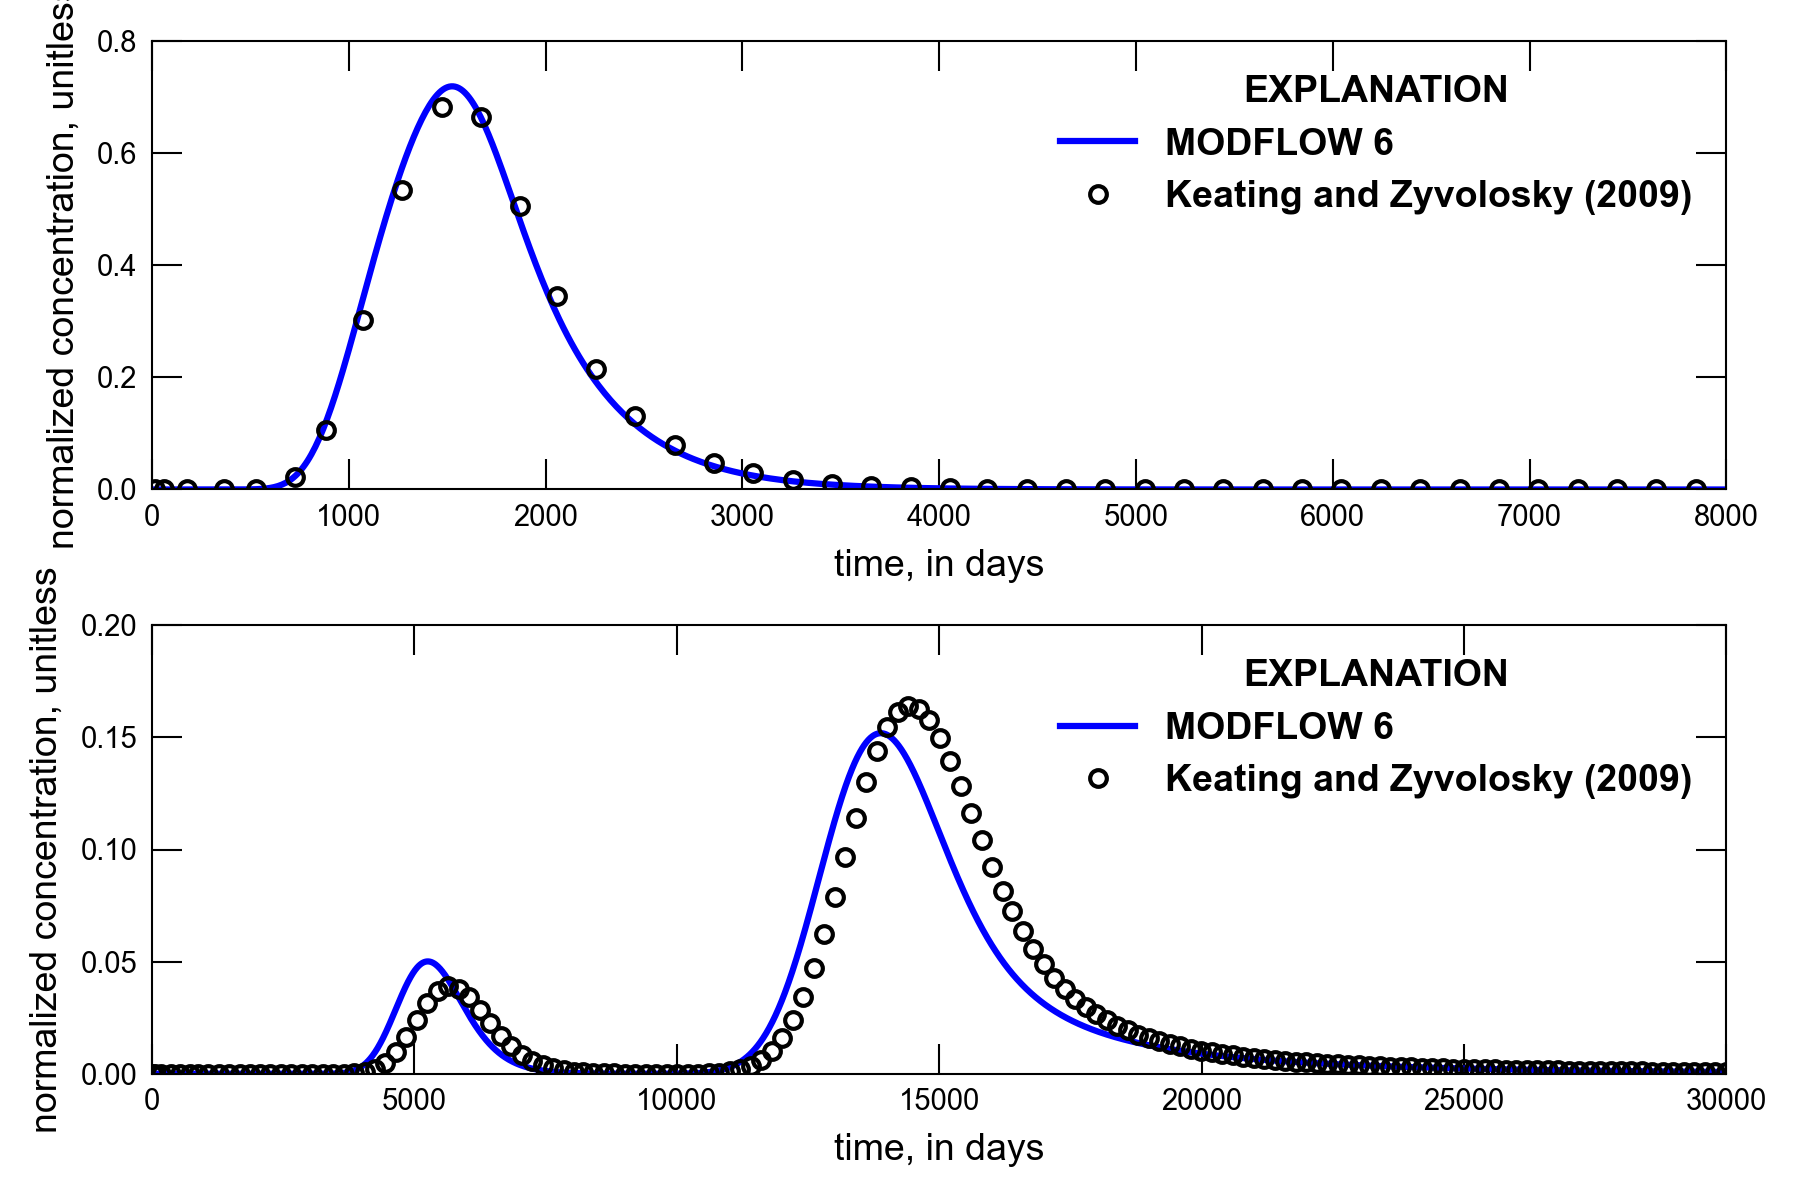

Animating conc model results...


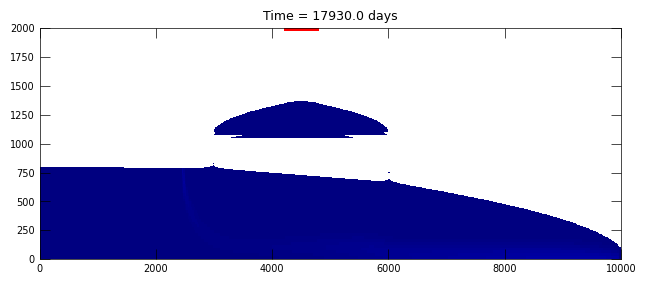

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim)


scenario()